## Data Analysis 
### Sub-Analytical Question:
#### **What are the trends in solar energy adoption across the conflict cycle—pre-conflict, active conflict, and post-conflict periods—in conflict-affected countries?**

In [ ]:
# 1. Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Visualization settings
%matplotlib inline
sns.set(style="whitegrid", palette="pastel")

In [11]:
# 2. Load Dataset

df = pd.read_excel(
    "../1_datasets/cleaned_data/ONG_conflictcountriesonly.xlsx",
    engine="openpyxl",
)

In [12]:
# 3. Quick Preview
print(df.head())
print("Shape of dataset:", df.shape)

   Region       Sub-region Country ISO3 code         RE or Non-RE  \
0  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
1  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
2  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
3  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   
4  Africa  Northern Africa   Libya       LBY  Total Non-Renewable   

  Group Technology   Technology Sub-Technology        Producer Type  Year  \
0     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2000   
1     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2001   
2     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2002   
3     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2003   
4     Fossil fuels  Natural gas    Natural gas  On-grid electricity  2004   

   Electricity Installed Capacity (MW) Conflict Phase  
0                                930.0   pre-conflict  
1         

In [13]:
# 14. SOLAR ENERGY DATAFRAME
solar_df = df[
    df["RE or Non-RE"].str.contains("Total Renewable", case=False, na=False)
    & df["Group Technology"].str.contains("Solar energy", case=False, na=False)
].copy()

solar_df.head()

,Region,Sub-region,Country,ISO3 code,RE or Non-RE,Group Technology,Technology,Sub-Technology,Producer Type,Year,Electricity Installed Capacity (MW),Conflict Phase
46,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2003,0.2,pre-conflict
47,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2004,0.7,pre-conflict
48,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2005,1.2,pre-conflict
49,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2006,1.7,pre-conflict
50,Africa,Northern Africa,Libya,LBY,Total Renewable,Solar energy,Solar photovoltaic,Off-grid Solar photovoltaic,Off-grid electricity,2007,2.2,pre-conflict


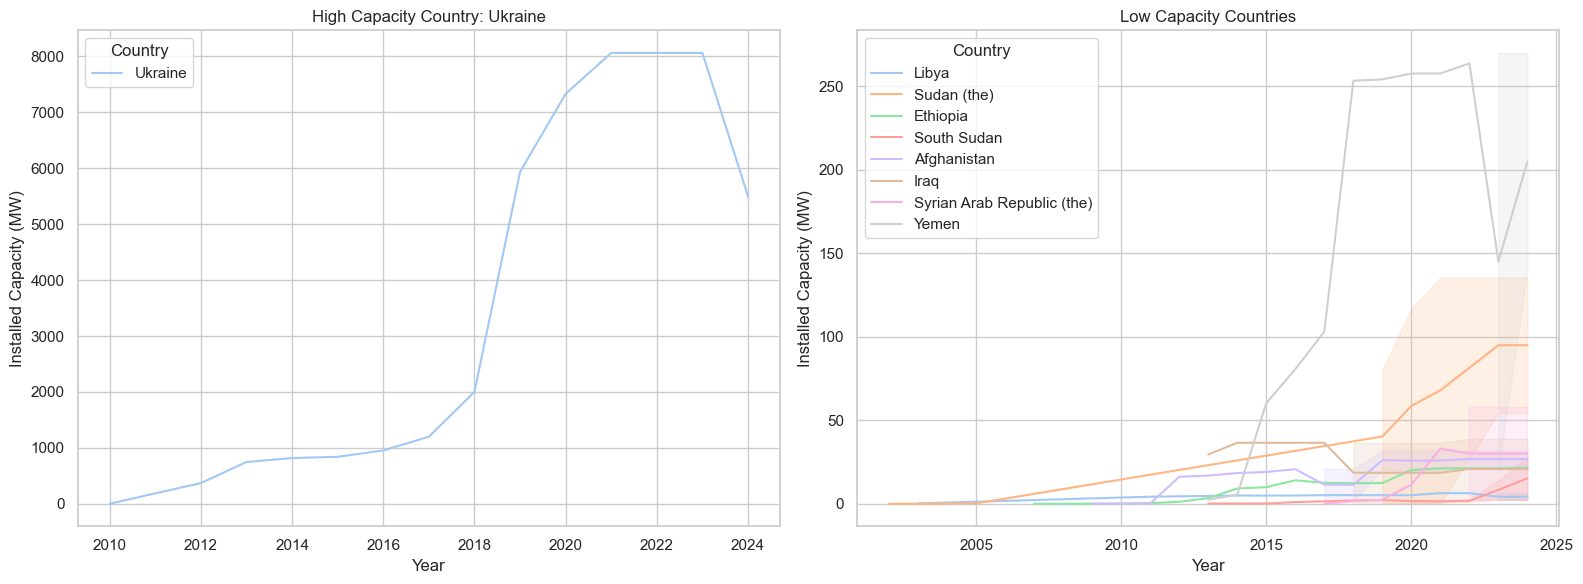

In [14]:
# 13. High vs Low Capacity
# Ukraine has much higher capacity than others, so we separate it
high_capacity_countries = ["Ukraine"]

# Getting all unique country names from our data
all_countries = solar_df["Country"].unique()

# Creating a list of countries that are NOT Ukraine (the low capacity ones)
low_capacity_countries = []
for country in all_countries:
    if country != "Ukraine":  # If it's not Ukraine
        low_capacity_countries.append(country)  # Add it to low capacity list

# Then creating two graphs side by side to see difference
fig, (left_graph, right_graph) = plt.subplots(1, 2, figsize=(16, 6))
# 1 = one row, 2 = two columns, figsize makes it wide enough for both

# The LEFT graph (for high capacity countries)
# Filter our data to only include Ukraine
ukraine_data = solar_df[solar_df["Country"] == "Ukraine"]

# Plotting Ukraine's data on the left graph
sns.lineplot(
    data=ukraine_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=left_graph,
)

# Adding labels to the left graph
left_graph.set_title("High Capacity Country: Ukraine")
left_graph.set_ylabel("Installed Capacity (MW)")
left_graph.set_xlabel("Year")

# The RIGHT graph (for low capacity countries)
# Filter our data to exclude Ukraine (keep all others)
other_countries_data = solar_df[solar_df["Country"] != "Ukraine"]

# Plotting all other countries 8 on the right graph
sns.lineplot(
    data=other_countries_data,
    x="Year",
    y="Electricity Installed Capacity (MW)",
    hue="Country",
    ax=right_graph,
)

# Add labels to the right graph
right_graph.set_title("Low Capacity Countries")
right_graph.set_ylabel("Installed Capacity (MW)")
right_graph.set_xlabel("Year")

plt.tight_layout()
plt.show()

# - Left graph: Ukraine's dramatic growth (large numbers)
# - Right graph: All other countries (smaller numbers, but now visible!)

**Key Finding:** _Ukraine's solar energy_ capacity is dramatically higher than all other countries in the dataset, with over _8,000 MW_ by 2024 compared to less than _250 MW_ for any other country. This 30-40x difference is so extreme that Ukraine must be analyzed separately from other countries (Libya, Syria, Sudan, Ethiopia, South Sudan, Afghanistan, Iraq, Yemen) to make meaningful comparisons, as Ukraine's exponential growth from 2016-2022 completely dominates the scale and obscures patterns in the remaining countries.

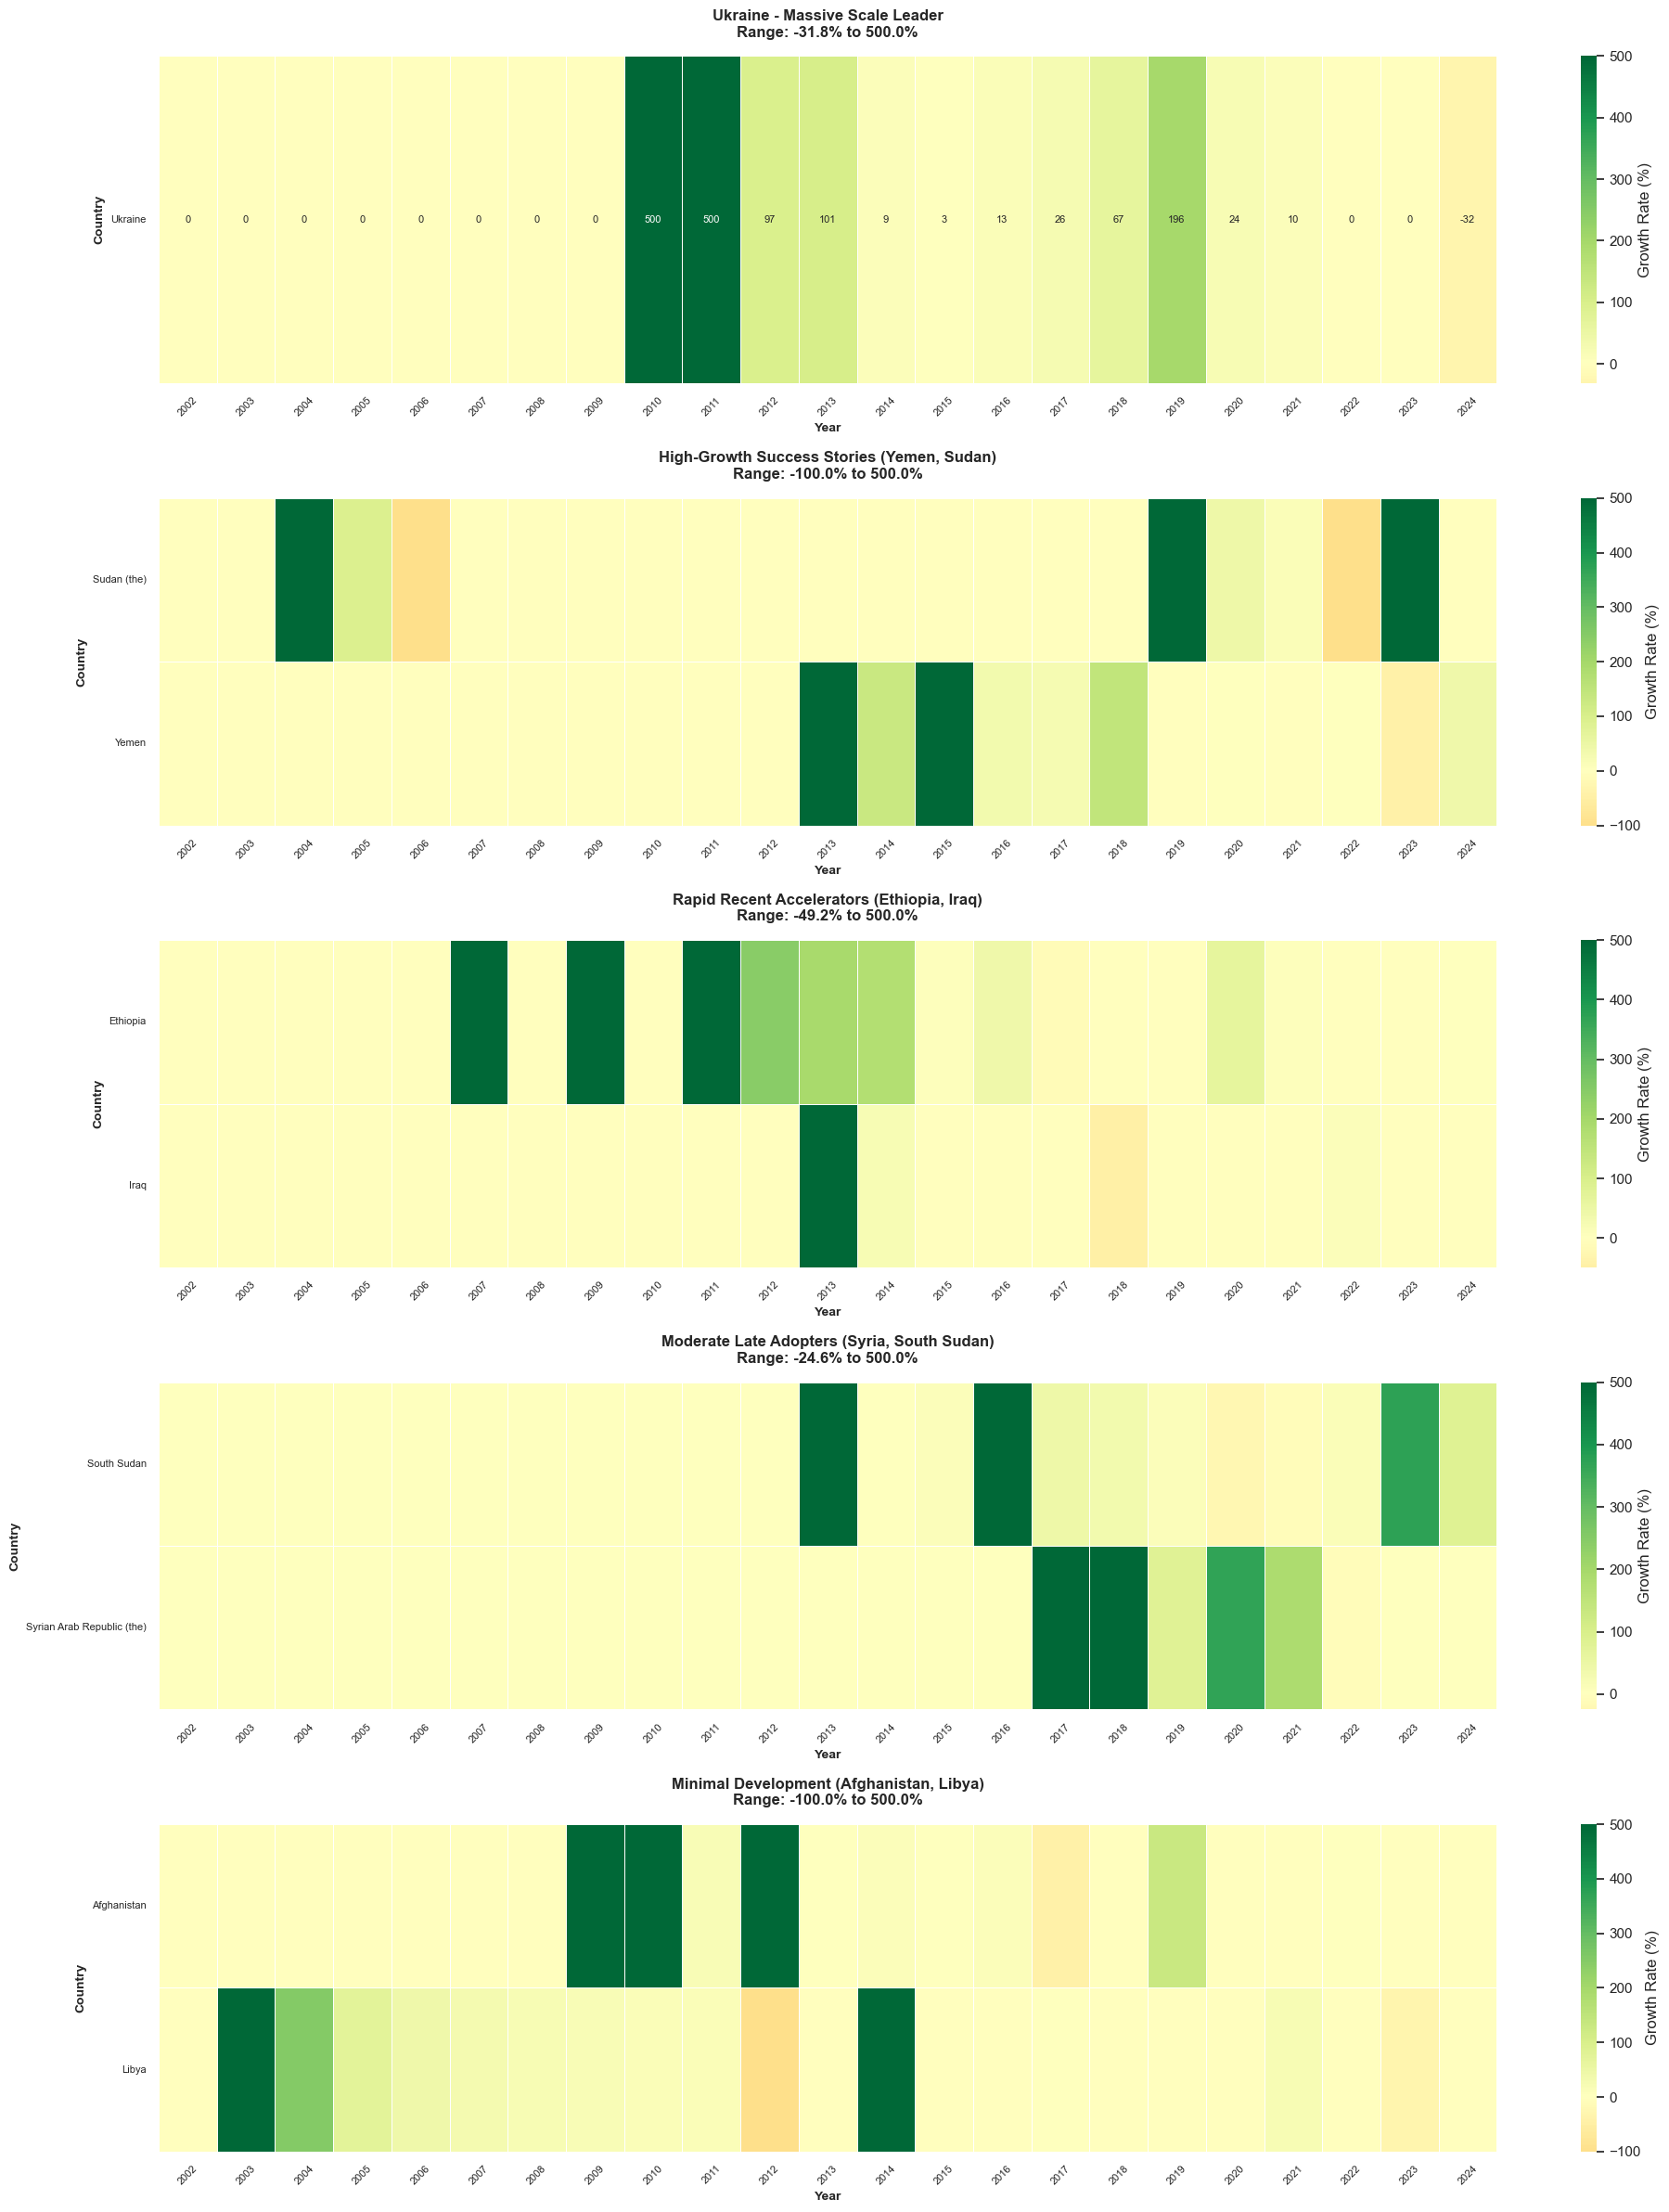

In [15]:
# Step 1: Prepare the data for heatmap format
heatmap_data = solar_df.pivot_table(
    index="Country",
    columns="Year",
    values="Electricity Installed Capacity (MW)",
    fill_value=0,
)


# Step 2: Calculate year-over-year growth rates
def calculate_growth_rates(data):
    growth_data = data.copy()
    growth_data.iloc[:, 0] = 0  # First year = 0% growth
    for country in growth_data.index:
        for i in range(1, len(growth_data.columns)):
            prev_year = growth_data.columns[i - 1]
            curr_year = growth_data.columns[i]
            prev_capacity = data.loc[country, prev_year]
            curr_capacity = data.loc[country, curr_year]
            if prev_capacity == 0:
                growth_data.loc[country, curr_year] = 500 if curr_capacity > 0 else 0
            else:
                growth_rate = ((curr_capacity - prev_capacity) / prev_capacity) * 100
                growth_data.loc[country, curr_year] = min(max(growth_rate, -100), 500)
    return growth_data


all_growth_data = calculate_growth_rates(heatmap_data)

# Step 3: Group countries by similar patterns
ukraine_growth = all_growth_data[all_growth_data.index == "Ukraine"]
group2_growth = all_growth_data[all_growth_data.index.isin(["Yemen", "Sudan (the)"])]
group3_growth = all_growth_data[all_growth_data.index.isin(["Ethiopia", "Iraq"])]
group4_growth = all_growth_data[
    all_growth_data.index.isin(["Syrian Arab Republic (the)", "South Sudan"])
]
group5_growth = all_growth_data[all_growth_data.index.isin(["Afghanistan", "Libya"])]

# Step 4: Plot heatmaps
fig, axes = plt.subplots(5, 1, figsize=(20, 24))

heatmap_params = {
    "cmap": "RdYlGn",
    "center": 0,
    "linewidths": 0.5,
    "linecolor": "white",
    "square": False,
    "fmt": ".0f",
}

sns.heatmap(
    ukraine_growth,
    annot=True,
    annot_kws={"fontsize": 8},
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[0],
    **heatmap_params,
)
axes[0].set_title(
    f"Ukraine - Massive Scale Leader\nRange: {ukraine_growth.min().min():.1f}% to {ukraine_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group2_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[1],
    **heatmap_params,
)
axes[1].set_title(
    f"High-Growth Success Stories (Yemen, Sudan)\nRange: {group2_growth.min().min():.1f}% to {group2_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group3_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[2],
    **heatmap_params,
)
axes[2].set_title(
    f"Rapid Recent Accelerators (Ethiopia, Iraq)\nRange: {group3_growth.min().min():.1f}% to {group3_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group4_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[3],
    **heatmap_params,
)
axes[3].set_title(
    f"Moderate Late Adopters (Syria, South Sudan)\nRange: {group4_growth.min().min():.1f}% to {group4_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

sns.heatmap(
    group5_growth,
    annot=False,
    cbar_kws={"label": "Growth Rate (%)"},
    ax=axes[4],
    **heatmap_params,
)
axes[4].set_title(
    f"Minimal Development (Afghanistan, Libya)\nRange: {group5_growth.min().min():.1f}% to {group5_growth.max().max():.1f}%",
    fontsize=12,
    fontweight="bold",
    pad=15,
)

# Customize all axes
for ax in axes:
    ax.set_xlabel("Year", fontsize=10, fontweight="bold")
    ax.set_ylabel("Country", fontsize=10, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

**Key Findings:**

 **When Countries Started Building Solar Power**

 **Time Periods**
1. **2009-2010**: Ukraine and Afghanistan started big projects
2. **2004-2006**: Sudan began building solar power
3. **2018-2022**: Yemen and Iraq got serious about solar
4. **2020-2025**: Syria and South Sudan joined in recently

 **How Fast They Grew**

 **Growth Speed**
- **500% growth**: Means they built A LOT very quickly (like going from 1 to 5 solar farms)
- **Steady vs. Stop-and-Go**: Ukraine and Yemen kept building consistently; others built in short bursts then stopped
- **Negative growth**: Sometimes they had less solar power than before (maybe some broke down)

 **Three Waves of Countries**

 **The Waves**
1. **Early Starters** (2004-2010): Sudan, Ukraine, Ethiopia went first
2. **Middle Joiners** (2015-2018): Syria, South Sudan joined later
3. **Recent Joiners** (2018-2025): Yemen, Iraq are newest
4. **Barely Tried**: Afghanistan, Libya hardly built any solar

 **Main Point**
All countries can grow solar power really fast when they start (500% growth), but most countries only did it for a short time and then stopped. Ukraine was the only one that kept building solar power for many years, which is why they have so much more than everyone else.